# ML Article Classification

Articles can have up to 10 tags associated with them.

A range of methods/solutions have been tried.

Key problems: Label Dependency, Label counts, correctness of label classifications

In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append('scripts/')
from utility import *
import spacy
nlp = spacy.load("en_core_web_sm") # English Model
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS # stop words
from time import perf_counter

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42

import warnings
warnings.filterwarnings('ignore')

In [48]:
data = pd.read_csv('data/article_data.csv', usecols=)
data.head()

,url,text,tag_list,text_clean,tag_tips and tricks_cleaning,tag_tips and tricks,tag_diy detergents,tag_100% natural,tag_general bathroom cleaning,tag_housekeeping,...,tag_sustainability fast fashion,tag_social media discoverer,tag_social media consumer,tag_sustainability plastic_free,tag_sustainability_newcomer,tag_domestic_staycation,tag_vegan mindset,raw_text,text_norm,path_title
0,https://www.cleanipedia.com/gb/bathroom-cleani...,Distilled vinegar can be used in many differen...,"['tips and tricks_cleaning', 'tips and tricks'...",distil vinegar use mani differ way around home...,1,1,1,1,1,1,...,0,0,0,0,0,0,0,White Wine Vinegar for Cleaning: Using Vinegar...,White Wine vinegar clean vinegar clean Bathroo...,bathroom cleaning with white vinegar
1,https://www.cleanipedia.com/gb/bathroom-cleani...,"Everyone likes their bathroom to look good, fu...","['storage', 'home decor', 'home decor', 'tips ...",everyon like bathroom look good function well ...,0,1,0,0,1,0,...,0,0,0,0,0,0,0,Bathroom décor ideas that save space – and cle...,Bathroom dcor idea save space clean easily bat...,bathroom decor ideas that save space and clean...
2,https://www.cleanipedia.com/gb/bathroom-cleani...,"Toilet seats are a hive of bacteria, and altho...","['anti bac', 'disinfection', 'germ transmissio...",toilet seat hive bacteria although germ surviv...,0,1,0,0,0,0,...,0,0,0,0,0,0,0,Can you catch diseases from toilet seat surfac...,catch disease toilet seat surface answer quest...,can you catch diseases from toilet seat
3,https://www.cleanipedia.com/gb/bathroom-cleani...,Key Steps\nRemember these 5 rules to cleaning ...,"['bath', 'tips and tricks_cleaning', 'sanitati...",key stepsrememb 5 rule clean bathtubchoos righ...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,How to clean an enamel bathtub Bathing in a di...,clean enamel bathtub Bathing dirty enamel bath...,clean bathtub
4,https://www.cleanipedia.com/gb/bathroom-cleani...,Key Points:\n\nDon’t overlook the effect of li...,"['tips and tricks_cleaning', 'toilet_toilet cl...",key pointsdont overlook effect limescal toilet...,1,1,0,0,0,0,...,0,0,0,0,0,0,0,How to clean a toilet bowl and remove toilet b...,clean toilet bowl remove toilet bowl stain lik...,clean toilet bowl remove limescale


## Extract Article Text

In [7]:
import requests
from bs4 import BeautifulSoup

def extract_article(url: str):
    response = requests.get(url, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
    
    body = ''.join([text.get_text() for text in soup.find_all('section','article-text')])
    
    warning_message = soup.find('section','mb-8 Warning')
    if warning_message != None:
        warning_message = warning_message.get_text()
    else:
        warning_message = ''
        
    summary = soup.find('span','callout')
    if summary != None:
        summary = summary.get_text()
    else:
        summary=''
        
    title = soup.find('h1').get_text()
    sub_title = soup.find('p').get_text()
    
    return title + ' ' + sub_title + ' ' + summary + ' ' + body + ' ' + warning_message

In [8]:
start = perf_counter()

data['raw_text'] = data['url'].apply(lambda url: extract_article(url))

end = perf_counter()
execution_time = (end - start)
print(f'Runtime: {execution_time:.2f}s / {execution_time/60:.2f}mins')

Runtime: 833.89s / 13.90mins


In [ ]:
tag_names = dict([(tag, f'tag_{tag}') for tag in data.iloc[:,4:-1].columns])
data = data.rename(columns=tag_names)
tag_cols = list(data.iloc[:,4:-1].columns)

### Tag Counts

In [4]:
def count_labels(label_data, labels: list):
    """
        returns label counts for all labels
        
        label_data - binary data indicating label presence
        labels - label names
    """
    if type(label_data) != 'pandas.core.frame.DataFrame':
        label_data = pd.DataFrame(label_data, columns = labels)
        
    return pd.DataFrame([(label, sum(label_data[label])) for label in labels], columns=['Label', 'Count']).sort_values(by='Count', ascending=False)

In [ ]:
tag_counts = count_labels(data, tag_cols)
tag_counts.style.hide_index()

In [159]:
tag_cols = list(tag_counts['Label'].loc[tag_counts['Count'] >= 50].values)

# Text Preprocess

In [ ]:
start = perf_counter()

data['text_norm'] = normalise_text(data['raw_text'], remove_digit=False, stopword=spacy_stopwords)

end = perf_counter()
execution_time = (end - start)
print(f'Runtime: {execution_time:.2f}s / {execution_time/60:.2f}mins')

In [ ]:
# URL path title
titles = []
for url in data['url']:
    title = url.replace('.', '/').split('/')[-2]
    titles.append(' '.join(word for word in title.split('-')))
data['path_title'] = titles

In [377]:
corpus = data['path_title'] + data['text_norm']

# Feature Engineering

In [ ]:
# Word Count
data['char_count'] = data['text'].apply(len)
# Character Count
data['word_count'] = data['text'].apply(lambda text: len(text.split()))
# Punctuation count
data['punctuation_count'] = data['text'].apply(lambda text: count_punct(text))
# Upper Case count
data['upper_case_word_count'] = data['text'].apply(lambda text: count_upper(text))
#Entity Count
data['entity_count'] = data['text'].apply(lambda text: count_entities(text))

In [ ]:
# POS type counts
data['noun_count'] = data['text'].apply(lambda text: count_pos_type(text, 'noun'))
data['verb_count'] = data['text'].apply(lambda text: count_pos_type(text, 'verb'))
data['adj_count'] = data['text'].apply(lambda text: count_pos_type(text, 'adjective'))
data['adv_count'] = data['text'].apply(lambda text: count_pos_type(text, 'adverb'))
data['pron_count'] = data['text'].apply(lambda text: count_pos_type(text, 'pronoun'))

## Information Gain

In [ ]:
def sum_IG(text, IG_dict: dict):
    return sum([IG_dict[word] for word in text.split() if word in IG_dict.keys()])/len(text.split())

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

binary_vector = CountVectorizer(ngram_range=(1,1), min_df=2, binary=True)
data_binary_vector = binary_vector.fit_transform(corpus)

start = perf_counter()

vocab = binary_vector.get_feature_names()

IG_mat = np.zeros(shape=(len(data),len(tag_cols)))
                  
for i in range(IG_mat.shape[1]):
    IG_scores =  dict(zip(vocab,
                               mutual_info_classif(
                               csr_matrix(data_binary_vector), data[tag_cols[i]],
                               discrete_features=True,
                               random_state=RANDOM_STATE
                                  )
                                ))
    for j in range(len(data['text_norm'])):
        IG_mat[j][i] = sum_IG(data['text_norm'][j], IG_scores)

end = perf_counter()
execution_time = (end - start)
print(f'Runtime: {execution_time:.2f}s / {execution_time/60:.2f}mins')

In [ ]:
IG_features = pd.DataFrame(IG_mat, index=data.index, columns = [f'IG_{tag}' for tag in tag_cols])

In [ ]:
feature_cols = ['char_count','word_count','punctuation_count','upper_case_word_count','noun_count','verb_count','adj_count','adv_count','pron_count','entity_count']

# Word Embedding

### TF-IDF Matrix

In [396]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vector = TfidfVectorizer(ngram_range=(1,1), min_df=1)
data_tfidf_vec = tfidf_vector.fit_transform(corpus)

# Feature Selection

### Chi-Squared

Using the chi2 value to select n highest features for each label. Higher the value the greater the dependence of a set of features with a label

In [160]:
from scipy.sparse import csr_matrix
from sklearn.feature_selection import chi2

start = perf_counter()

mat_chi2 = np.zeros(shape=(len(tag_cols), data_tfidf_vec.shape[1]))

for i in range(mat_chi2.shape[0]):
    score, _ = chi2(csr_matrix(data_tfidf_vec), data[tag_cols[i]])
    mat_chi2[i] = score
    
end = perf_counter()
execution_time = (end - start)
print(f'Runtime: {execution_time:.2f}s / {execution_time/60:.2f}mins')

Runtime: 1.38s / 0.02mins


In [10]:
def chi2_per_label(chi2_values, n: int):
    """
        returns n words for each label having the highest chi2 value
        
        chi2_values - chi2 matrix (n,m) n- labels, m-features
        n - top n most words
    """
    chi2_data = pd.DataFrame(chi2_values, index=tag_cols, columns = tfidf_vector.get_feature_names())
    words = set()
    for label in chi2_data.index:
        words.update(chi2_data.loc[label,:].sort_values(ascending=False).index[:n])
    print(f'{len(words)}/{len(tfidf_vector.get_feature_names())} Word Features')
    return words

In [161]:
selected_features = chi2_per_label(mat_chi2, 2500)

39093/209932 Word Features


In [397]:
# word vector dataframe
data_tfidf = pd.DataFrame(data_tfidf_vec.toarray(), columns=tfidf_vector.get_feature_names())
# features dataframe
data_features = pd.concat([data_tfidf, data[tag_cols]], axis=1)
# drop rows with all zeros
data_features = data_features.loc[~(data_features[tag_cols]==0).all(axis=1)]

# Label Dependency

In [ ]:
from scipy.sparse import csr_matrix
from sklearn.feature_selection import chi2

start = perf_counter()

mat_chi2 = np.zeros(shape=(len(tag_cols), len(tag_cols)))

for i in range(mat_chi2.shape[0]):
    score, _ = chi2(data[[tag for tag in tag_cols if tag != tag_cols[i]]], data[tag_cols[i]])
    score = np.insert(score, i, 1)
    mat_chi2[i] = score

chi2_dependency = pd.DataFrame(mat_chi2)
end = perf_counter()
execution_time = (end - start)
print(f'Runtime: {execution_time:.2f}s / {execution_time/60:.2f}mins')

In [ ]:
tag_counts = count_labels(data, tag_cols)

In [ ]:
def create_clusters(dependecy_data, threshold: int, counts: list):
    """
        returns list of clusters containing the index of labels based on the chi squared value (dependencies) for a label
        
        dependecy_data - chi square labelxlabel matrix
        threshold - chi squared value to accept as dependent label
        counts - label counts
    """
    clusters = []
    others = []
    for i in range(len(tag_cols)):
        dependants = list(chi2_dependency.iloc[i,:][chi2_dependency.iloc[i,:].sort_values(ascending=False)>threshold].index)
        if len(dependants) > 0:
            dependants.append(chi2_dependency.iloc[i,:].name)
            clusters.append(dependants)
        elif len(dependants) == 0:
            others.append(chi2_dependency.iloc[i,:].name)
    if others:
        clusters.append(others)
    # Merge Clusters that are similar i.e. have a difference of at least 1 tag
    merged_clusters = []
    for cluster in clusters:
        new_cluster = set(cluster)
        other_clusters = [cluster_ for cluster_ in clusters if cluster_ != cluster]
        for cluster_ in other_clusters:
            if len(set(cluster) - set(cluster_)) <= 1:
                new_cluster = new_cluster.union(set(cluster_))
                clusters.remove(cluster_)
        new_cluster = [tag for _,tag in sorted(zip(counts,new_cluster))]
        merged_clusters.append(list(new_cluster))
    return merged_clusters

In [ ]:
clusters = create_clusters(chi2_dependency, 50, tag_counts['Count'].values)

# Resampling

## Label Decoupling

Implementation based on the REMEDIAL Method from paper - https://arxiv.org/pdf/1802.05031.pdf

See paper for details on the formulas

<b>IRLbl</b> (Individual label imbalance) - Count of the most frequent label in a label set / Count of the individual label

<b>mean_IR</b> - Global label imbalance - mean IRLbl

<b>SCUMBLE</b> - Metric the indicates the level of concurrence between common and rare labels whose values will be in the [0, 1] range. The higher the value the more instances containing minority and majority labels exist in the MLD.

<b>REMEDIAL</b> Algorithm - looks for instances that contain both majority and minority labels and decouples them, creating a copy that contains only the majority labels, whilst maintaining the minority labels in the original instance and append the copy to the dataset.


In [ ]:
def frequent_label(data, labels):
    return max([sum(data[label].values) for label in labels])

def IRLbl(Series, most_frequent):
    return most_frequent / sum(Series.values)

def mean_IR(data, labels, most_frequent, vals=[]):
    IRLbls = []
    if len(vals) > 0:
        IRLbls = vals
    else:
        IRLbls = [IRLbl(data[label], most_frequent) for label in labels]
    return sum(IRLbls) / len(IRLbls)

In [ ]:
def SCUMBLE(data, labels):
    """
        returns scumble values for each instance and the mean scumble value for the dataset
        
        data - DataFrame
        labels - class label names
    """
    scumble = []
    for i in range(data[labels].shape[0]):
        labels_ = data[labels].iloc[i, :][data[labels].iloc[i, :] > 0].index
        most_frequent = frequent_label(data, labels_)
        scumble.append(1 - \
                       ((1/mean_IR(data, labels_, most_frequent))\
                        * (np.prod([IRLbl(data[label], most_frequent) for label in labels_])\
                           **(1/len(labels_)))))
        
    return scumble, (sum(scumble) / len(scumble))

In [ ]:
def REMEDIAL(data, labels, threshold=None):
    """
        returns data with instances containing majority/minority samples decoupled
        
        data - DataFrame
        labels - class label names
    """
    most_frequent = frequent_label(data, labels)
    IRLbls = [IRLbl(data[label], most_frequent) for label in labels]
    mean_IR_ = mean_IR(data, labels, most_frequent, vals=IRLbls)
    IRLbls_ref = dict(zip(labels,IRLbls)) # Individual imbalance look-up
    scumble_vals, scumble_ = SCUMBLE(data, labels)
    if not threshold:
        threshold = scumble_
    for i in range(data[labels].shape[0]): # For each article
        if scumble_vals[i] > threshold:
            d = data.loc[i, :]
            labels_ = data[labels].loc[i, :][data[labels].loc[i, :] > 0].index
            majority_labels = [label for label in labels_ if IRLbls_ref[label] <= mean_IR_]
            minority_labels = [label for label in labels_ if IRLbls_ref[label] > mean_IR_]
            if majority_labels and minority_labels:
                d_ = d.copy()
                d_.loc[majority_labels] = 0 # maintain minority labels
                d.loc[minority_labels] = 0 # maintain majority labels
                data = data.append(d_, ignore_index=True)
    return data

In [ ]:
data_features_ = REMEDIAL(data_features, tag_cols, threshold=0.25)

## TO TRY: Multi Label Sampling

# Model

3 Main approaches 

- Binary Relevance

- Classifier Chain

- Adaptive Algorithm

### Data Shuffle/Split

In [399]:
# Randomly shuffle all rows
data_features = data_features.sample(frac=1, random_state=RANDOM_STATE)
data_features = data_features.sample(frac=1, random_state=RANDOM_STATE)
data_features = data_features.sample(frac=1, random_state=RANDOM_STATE)

In [400]:
from skmultilearn.model_selection import iterative_train_test_split

X = data_features.drop(tag_cols, axis = 1)
y = data_features[tag_cols]

X_train, y_train, X_test, y_test = iterative_train_test_split(X.to_numpy(), y.to_numpy(), test_size = 0.3)

In [ ]:
count_labels(y_train, tag_cols).style.hide_index()

In [ ]:
count_labels(y_test, tag_cols).style.hide_index()

## Classifier Chain

Approach is good for taking in to account label dependencies

In [401]:
from sklearn.naive_bayes import MultinomialNB
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# nb_classifier = ClassifierChain(
#     classifier = MultinomialNB(alpha=0.0)
# )

nb_classifier = ClassifierChain(
    classifier = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
)

## Majority Voting CC

In [ ]:
from skmultilearn.ensemble import MajorityVotingClassifier
from skmultilearn.cluster import FixedLabelSpaceClusterer

nb_classifier = MajorityVotingClassifier(
    classifier = ClassifierChain(
        classifier = MultinomialNB(alpha=0.0)
    ),
    clusterer = FixedLabelSpaceClusterer(clusters=clusters)
)

## Parameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': np.linspace(100, 500, num=3, dtype=int),
        'classifier__min_samples_leaf': np.linspace(1, 50, num=5, dtype=int),
        'classifier__oob_score': [True, False]
    },
]

clf = GridSearchCV(ClassifierChain(), parameters, scoring='f1_samples', cv=3, n_jobs=-1)

clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)

In [402]:
nb_classifier = nb_classifier.fit(X_train, y_train)

### Predict

In [403]:
y_prob = nb_classifier.predict_proba(X_test)
t = 0.1 # threshold value
y_pred = (y_prob.toarray() >= t).astype(int)

In [404]:
top_pred = (-np.sort(-y_prob.toarray()) >= t).astype(int)[:,:10]
label_pred = list(zip((np.argsort(-y_prob.toarray()))[:,:10], top_pred))

## Evaluate Model

In [389]:
def compare_labels(pred, true, instance: int):
    """
        Compares the predicted/true labels for a given instance
        
        pred - model predicted values
        true - y_test values
    """
    pred_labels = [tag_cols[i] for i in label_pred[instance][0]]
    pred = pd.Series(label_pred[instance][1], index=pred_labels)
    pred_labels = pred[pred > 0].index
    
    true = pd.DataFrame(true, columns=tag_cols)
    true_labels = true.iloc[instance,:][true.iloc[instance,:] > 0].index
    
    output = pd.DataFrame([list(true_labels), list(pred_labels), list(set(true_labels).intersection(set(pred_labels)))], index=['True Labels', 'Predicted Labels', 'Common Labels'])
    return output.T.fillna('')

In [413]:
instance = 6
compare_labels(y_pred, y_test, instance)

,True Labels,Predicted Labels,Common Labels
0,tag_tips and tricks,tag_tips and tricks,tag_tips and tricks
1,tag_tips and tricks_cleaning,tag_sustainability eco_friendly,tag_home decor
2,tag_home decor,tag_tips and tricks_cleaning,tag_sustainability eco_friendly
3,tag_sustainability eco_friendly,tag_sustainability,tag_tips and tricks_cleaning
4,,tag_tutorials,
5,,tag_sustainability_sustainable living,
6,,tag_home decor,
7,,tag_diy at home,


#### Corresponding Article

In [411]:
for i, row in enumerate(data_features.drop(tag_cols, axis=1).values):
    if list(X_test[instance]) == list(row):
        break
print(data.loc[data_features.index[i], 'raw_text'])

Powerful laundry detergent: how and when to use them Sometimes you just need a powerful laundry detergent to lift a particularly difficult stain. But how and when is it best to use them? Find out here! Use a high quality detergent, like Persil, and always test on a small, inconspicuous piece of fabric if using it as a pre-treatment and use only as directed on the packaging. Key steps

 When pre-treating a stain, use a soft toothbrush to gently work the detergent into the fabric. 
Follow any special instructions on the detergent packet, remembering that capsules go into the drum of the washing machine before your clothes.
Wash at 30° C - it's better for your clothes and the environment.

We’ve all been there – you’ve tried all the usual tricks (salt on the red wine, instant soaking of the tomato sauce stain), but some marks just don’t shift that easily. Sometimes it takes a strong, high-performance laundry detergent – like the power of Persil – to do the trick.
If you’re worried about P

In [406]:
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score

averages = ['micro', 'macro', 'weighted', 'samples']
jaccard_scores = []
for average in averages:
    jaccard_scores.append(jaccard_score(y_test, y_pred, average=average))
    
jaccard = pd.DataFrame(jaccard_scores, index = [average + ' avg' for average in averages], columns=['jaccard_score'])

np.round(pd.concat([pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.iloc[-4:, :3], jaccard], axis=1), 2)

,precision,recall,f1-score,jaccard_score
micro avg,0.38,0.79,0.52,0.35
macro avg,0.35,0.66,0.44,0.30
weighted avg,0.39,0.79,0.51,0.36
samples avg,0.42,0.81,0.52,0.38


Text(0.5, 1, ' Confusion Matrix - tag_malodour')

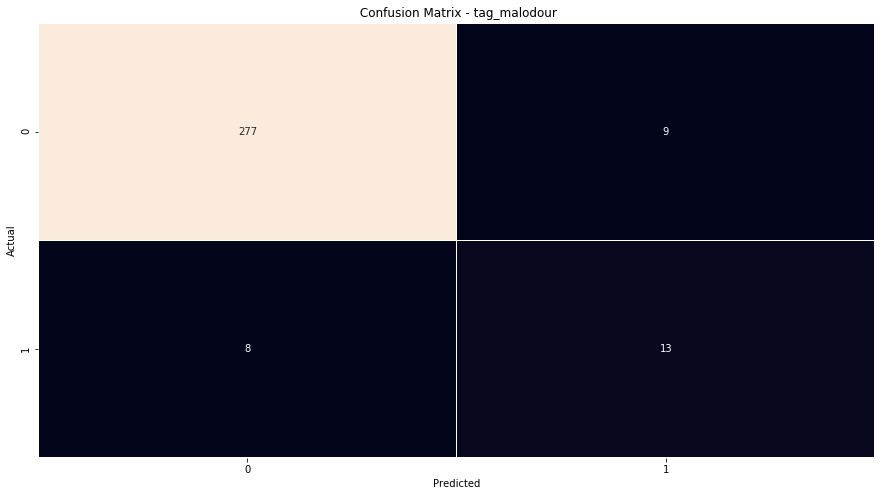

In [408]:
from sklearn.metrics import multilabel_confusion_matrix

tag_id = tag_cols.index('tag_malodour')
confusion = multilabel_confusion_matrix(y_test, y_pred)
fig, axis = plt.subplots(figsize=(15,8))
axis = sns.heatmap(confusion[tag_id], annot=True, fmt="d", linewidths=0.5, cbar=False)
axis.set(xlabel='Predicted', ylabel='Actual')
axis.set_title(f' Confusion Matrix - {tag_cols[tag_id]}')

In [393]:
def plot_feature_importance(model, features, n_words: int, labels: list, i: int):
    """
    
    """
    tags = labels.copy()
    tags = list(set(tags) - set(tags[i:]))
    
    if 'feature_importances_' in dir(model[i]):
        importance = model[i].feature_importances_
    elif 'coef_' in dir(model[i]):
        importance = abs(np.array(model[i].coef_).ravel())
    else:
        return None
    
    index = list(features) + tags
    feature_importances = pd.DataFrame(importance,
                                   index = index,
                                   columns=['importance']).sort_values('importance', ascending=False)
    
    name = remove_special_characters(str(model.__class__).split('.')[-1])
    
    fig, axis = plt.subplots(1, 1, figsize=(15,5))
    feature_importances[:n_words].plot.bar(ax=axis, legend=False)
    plt.title(f'Feature importances - {name} - Label - {tag_cols[i]}', fontsize=18)
    plt.ylabel('Relative Importance')

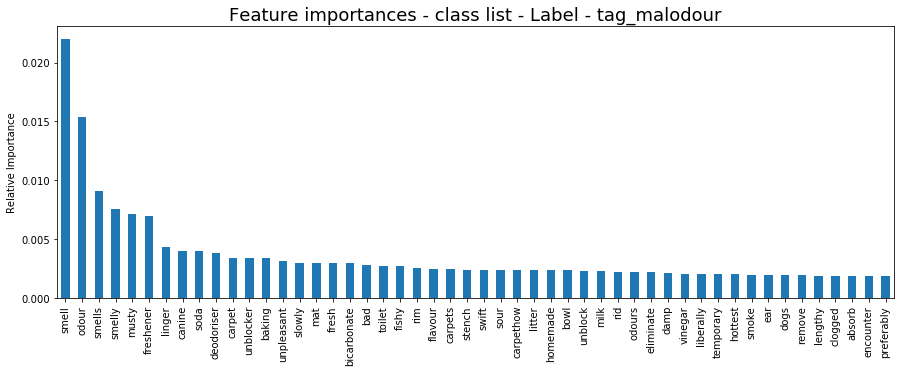

In [409]:
plot_feature_importance(nb_classifier.classifiers_, X.columns, 50, tag_cols, tag_cols.index('tag_malodour'))